<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/module3/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

## Yesterday's work

In [0]:
import sys

if 'google.colab' in sys.modules:
  dhs_foia_fy2018_data = 'https://github.com/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/data/dhs_foia_fy2018.csv?raw=true'
  !pip install -U --quiet pandas-profiling category_encoders eli5
else:
  dhs_foia_fy2018_data = '../data/dhs_foia_fy2018.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(dhs_foia_fy2018_data)
print('Shape:', df.shape)

Shape: (125143, 13)


In [0]:
random_state = 13

In [0]:
agencies = {
    'CISA':'Cybersecurity and Infrastructure Security Agency',
    'FEMA':'Federal Emergency Management Agency',
    'FLETC':'Federal Law Enforcement Training Centers',
    'I&A':'Office of Intelligence and Analysis',
    'ICE':'U.S. Immigration and Customs Enforcement',
    'OIG':'Office of Inspector General',
    'PRIV':'Privacy Office',
    'S&T':'Science and Technology Directorate',
    'TSA':'Transportation Security Administration',
    'USCG':'United States Coast Guard',
    'USSS':'United States Secret Service'
}

In [0]:
target = 'Case Status'

In [6]:
# Correct for capitalization / extra spaces
# Combine all 'On Hold'+ categories into one 'On Hold' category

df[target] = df[target].str.replace('closed', 'Closed')
df[target] = df[target].str.replace('open ', 'Open')
df[target] = df[target].str.replace('On Hold.*', 'On Hold')
df[target].unique()

array(['Open', 'Closed', 'On Hold'], dtype=object)

In [7]:
df[target] = df[target].str.replace('On Hold', 'Open')
df[target].value_counts(normalize=True)

Closed    0.907985
Open      0.092015
Name: Case Status, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=random_state)
train, val = train_test_split(train, test_size=0.2, random_state=random_state)

train.shape, val.shape, test.shape

((80091, 13), (20023, 13), (25029, 13))

In [9]:
import pandas_profiling
train_profile = train.profile_report()
train_profile

In [0]:
#@title helper functions

def explore(column):
  print(column)
  print()
  print(column.describe())
  print()
  print(f'Nulls: {column.isnull().sum()}')
  if pd.api.types.is_numeric_dtype(column.dtype):
    print(f'Unique: {column.nunique()}')
    print(f'Mode: {column.mode()}')
  print()
  print(column.value_counts())
  print()
  print(column.unique()[:min(100, column.nunique())])
  if(column.nunique() >= 100):
    print(' ...')

datetime_to_fiscal_year = lambda dt : dt.year if dt.month < 10 else dt.year + 1

## Continue to clean and explore your data.

### Perfected

In [11]:
explore(train['Perfected'])

73523     NaN
3770      NaN
113675    NaN
63107     NaN
68610     NaN
         ... 
71108     NaN
52188     NaN
116113    NaN
77298     NaN
77944     NaN
Name: Perfected, Length: 80091, dtype: object

count           4801
unique           868
top       2018-05-22
freq              50
Name: Perfected, dtype: object

Nulls: 75290

2018-05-22    50
2018-08-16    35
2018-06-25    33
2016-07-28    33
2018-07-27    32
              ..
2014-12-03     1
2013-08-16     1
2015-08-05     1
2017-11-10     1
2014-06-17     1
Name: Perfected, Length: 868, dtype: int64

[nan '2017-12-08' '2018-01-18' '2017-12-07' '2017-11-13' '2017-08-14'
 '2016-07-27' '2015-07-16' '2018-01-02' '2018-04-09' '2017-03-28'
 '2018-04-25' '2017-09-29' '2017-09-25' '2018-05-01' '2018-08-31'
 '2017-04-25' '2017-07-05' '2017-10-24' '2016-05-04' '2018-03-30'
 '2017-04-07' '2018-08-09' '2018-07-18' '2018-03-27' '2017-06-07'
 '2018-08-23' '2018-08-20' '2015-05-18' '2018-03-13' '2017-12-15'
 '2017-01-03' '2013-01-22' '2017-01-30

In [12]:
# convert to pandas datetime

perf = pd.to_datetime(train['Perfected'], infer_datetime_format=True, errors='coerce')
perf

73523    NaT
3770     NaT
113675   NaT
63107    NaT
68610    NaT
          ..
71108    NaT
52188    NaT
116113   NaT
77298    NaT
77944    NaT
Name: Perfected, Length: 80091, dtype: datetime64[ns]

In [13]:
years = perf.transform(datetime_to_fiscal_year)
years.name = 'Fiscal Year Perfected'
# changing to strings for ease of plotting, for now
years = years.fillna(0).astype(int).astype(str).str.replace('^0$', '0000')
years

73523     0000
3770      0000
113675    0000
63107     0000
68610     0000
          ... 
71108     0000
52188     0000
116113    0000
77298     0000
77944     0000
Name: Fiscal Year Perfected, Length: 80091, dtype: object

In [14]:
years.value_counts()

0000    75290
2018     2971
2017     1125
2016      418
2015      160
2014       81
2013       37
2012        9
Name: Fiscal Year Perfected, dtype: int64

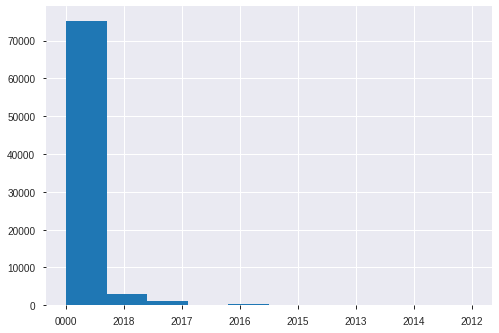

In [15]:
ax = years.hist()

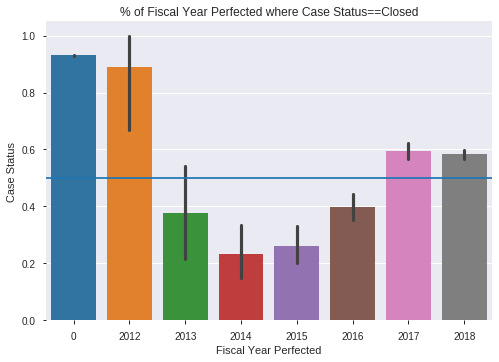

In [16]:
ax = sns.barplot(x=years.astype(int), y=train[target]=='Closed')
ax.axhline(y=0.5)
ax.set_title('% of Fiscal Year Perfected where Case Status==Closed')
plt.show()

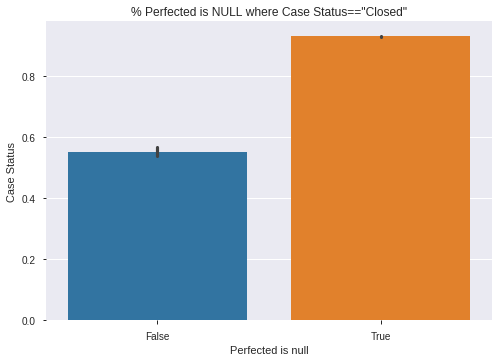

In [17]:
# get whether or not Perfected is null

p_null = perf.isna()
p_null.name = 'Perfected is null'

ax=sns.barplot(x=p_null, y=train[target]=='Closed')
ax.set_title('% Perfected is NULL where Case Status=="Closed"')
plt.show()

In [18]:
has_perfected = train[~train['Perfected'].isnull()]
has_perfected

,Request #,Agency,Initial Request Type,Track Type,Initial Received Date,Perfected,Case Status,Days Opened,Closed Date,Days to Process,Disposition,"Disposition ""Other"" Reason",Exemptions Used
124013,20180350,USSS,FOIA,Complex,2017-12-08,2017-12-08,Open,203.0,NaN,NaN,NaN,NaN,NaN
115198,2018-HQFO-00515,PRIV,HQ FOIA,Simple,2018-01-18,2018-01-18,Closed,5.0,2018-01-25,1.0,Other Reasons,D(2),NaN
124011,20180333,USSS,FOIA,Complex,2017-12-07,2017-12-07,Closed,NaN,2018-07-19,154.0,Other Reasons,D(1),NaN
42070,2018-IAFO-00042,I&A,Initial Request,Simple,2017-11-13,2017-11-13,Open,NaN,2017-11-21,6.0,Other Reasons,D(7),NaN
114294,2017-HQFO-01225,PRIV,HQ FOIA,Complex,2017-08-14,2017-08-14,Closed,77.0,2017-12-05,77.0,Granted/Denied in Part,NaN,"(b)(6),(b)(7)(E)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123228,20171493,USSS,Consultation,Complex,2017-03-22,2017-03-22,Open,384.0,NaN,NaN,NaN,NaN,NaN
116530,2017-TSFO-00254,TSA,TSA FOIA,Complex,2017-05-11,2017-05-11,Closed,319.0,2018-08-17,319.0,Granted in Full,NaN,NaN
117707,2015-TSCO-00002,TSA,TSA Consult,Complex,2015-03-18,2015-03-18,Open,889.0,NaN,NaN,NaN,NaN,NaN
123102,20171002,USSS,FOIA,Complex,2017-02-15,2017-02-15,Open,408.0,NaN,NaN,NaN,NaN,NaN


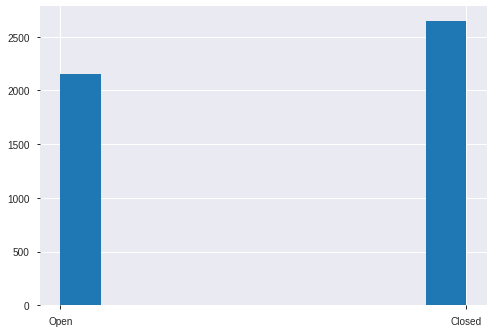

In [19]:
ax = has_perfected['Case Status'].hist()

In [20]:
has_perfected['Agency'].value_counts().sort_index()

FEMA    1024
I&A      216
PRIV    1076
S&T       80
TSA     1015
USSS    1390
Name: Agency, dtype: int64

In [21]:
train['Agency'].value_counts().sort_index()

CISA    25573
FEMA     1069
I&A       224
ICE     45734
OIG       266
PRIV     1329
S&T       140
TSA      1104
USCG     2924
USSS     1728
Name: Agency, dtype: int64

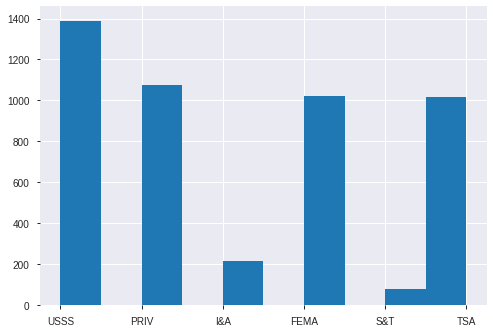

In [22]:
ax = has_perfected['Agency'].hist()

### Days Opened

In [23]:
explore(train['Days Opened'])

73523      2.0
3770       NaN
113675     NaN
63107     13.0
68610     22.0
          ... 
71108      6.0
52188      4.0
116113    27.0
77298      2.0
77944      2.0
Name: Days Opened, Length: 80091, dtype: float64

count    50162.000000
mean        26.671664
std        100.513000
min         -8.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       1631.000000
Name: Days Opened, dtype: float64

Nulls: 29929
Unique: 823
Mode: 0    1.0
dtype: float64

1.0       10586
2.0        7997
0.0        7638
3.0        4834
4.0        2723
          ...  
1219.0        1
477.0         1
948.0         1
617.0         1
526.0         1
Name: Days Opened, Length: 823, dtype: int64

[2.000e+00       nan 1.300e+01 2.200e+01 3.000e+00 0.000e+00 2.030e+02
 4.000e+00 1.000e+00 9.000e+00 1.000e+01 1.600e+01 2.000e+01 3.400e+01
 6.000e+00 5.000e+00 8.000e+00 2.400e+01 7.700e+01 5.380e+02 5.300e+01
 7.000e+00 8.050e+02 2.680e+02 3.200e+01 2.600e+01 2.300e+01 2.100e+01
 5.500e+01 1

### Closed Date

In [24]:
explore(train['Closed Date'])

73523     2018-06-01
3770      2018-05-18
113675    2018-08-03
63107     2018-08-02
68610     2018-07-24
             ...    
71108     2018-06-20
52188     2018-09-12
116113    2018-08-29
77298     2018-05-19
77944     2018-05-16
Name: Closed Date, Length: 80091, dtype: object

count          74140
unique           367
top       2018-09-28
freq             964
Name: Closed Date, dtype: object

Nulls: 5951

2018-09-28    964
2018-09-27    869
2018-09-25    796
2018-09-21    770
2018-09-20    683
             ... 
2018-06-24      1
2018-02-11      1
2018-10-24      1
2018-03-25      1
2017-10-22      1
Name: Closed Date, Length: 367, dtype: int64

['2018-06-01' '2018-05-18' '2018-08-03' '2018-08-02' '2018-07-24'
 '2017-11-27' '2018-07-25' '2018-02-15' '2018-05-31' nan '2018-05-22'
 '2017-11-07' '2018-08-15' '2017-10-16' '2017-11-02' '2018-02-01'
 '2018-07-12' '2018-07-06' '2017-12-01' '2017-10-26' '2018-03-30'
 '2018-06-22' '2018-09-28' '2018-03-02' '2017-11-03' '2018-01-16'
 '2018-07-2

### Days to Process

In [25]:
explore(train['Days to Process'])

73523      NaN
3770       NaN
113675     NaN
63107      NaN
68610      NaN
          ... 
71108      NaN
52188      NaN
116113    27.0
77298      NaN
77944      NaN
Name: Days to Process, Length: 80091, dtype: float64

count    4076.000000
mean       97.538027
std       181.319829
min         0.000000
25%         1.000000
50%        26.000000
75%       110.000000
max      1581.000000
Name: Days to Process, dtype: float64

Nulls: 76015
Unique: 549
Mode: 0    1.0
dtype: float64

1.0       1129
0.0        128
2.0         80
4.0         78
3.0         58
          ... 
303.0        1
458.0        1
1346.0       1
1332.0       1
258.0        1
Name: Days to Process, Length: 549, dtype: int64

[      nan 1.490e+02 1.000e+00 1.540e+02 6.000e+00 7.700e+01 5.380e+02
 3.500e+01 2.700e+01 3.000e+00 1.570e+02 6.000e+01 2.450e+02 3.800e+01
 1.560e+02 2.740e+02 1.270e+02 3.530e+02 1.130e+02 2.500e+01 5.000e+00
 2.000e+00 4.100e+01 1.830e+02 3.440e+02 4.700e+01 2.830e+02 1.300e+01
 4.000e+00 1.740e+0

### Disposition

In [26]:
explore(train['Disposition'])

73523     Granted/Denied in Part
3770      Granted/Denied in Part
113675            Denied in Full
63107     Granted/Denied in Part
68610     Granted/Denied in Part
                   ...          
71108     Granted/Denied in Part
52188     Granted/Denied in Part
116113             Other Reasons
77298     Granted/Denied in Part
77944     Granted/Denied in Part
Name: Disposition, Length: 80091, dtype: object

count                      74530
unique                         6
top       Granted/Denied in Part
freq                       55824
Name: Disposition, dtype: object

Nulls: 5561

Granted/Denied in Part    55824
Other Reasons             14551
Granted in Full            3007
Denied in Full             1146
upheld                        1
Partial Denial                1
Name: Disposition, dtype: int64

['Granted/Denied in Part' 'Denied in Full' 'Other Reasons' nan
 'Granted in Full' 'upheld']


### Disposition "Other" Reason

In [27]:
explore(train['Disposition "Other" Reason'])

73523                                                   NaN
3770      (b)(6),(b)(7)(C),(b)(7)(E),(b)(3):8 U.S.C.  12...
113675                                            (b)(7)(A)
63107                                                   NaN
68610                                                   NaN
                                ...                        
71108                                                   NaN
52188                                                   NaN
116113                                                 D(5)
77298                                                   NaN
77944                                                   NaN
Name: Disposition "Other" Reason, Length: 80091, dtype: object

count                          23093
unique                           111
top       (b)(6),(b)(7)(C),(b)(7)(E)
freq                           11726
Name: Disposition "Other" Reason, dtype: object

Nulls: 56998

(b)(6),(b)(7)(C),(b)(7)(E)                                       

### Exemptions Used

In [28]:
explore(train['Exemptions Used'])

73523                            (b)(6),(b)(7)(C),(b)(7)(E)
3770                                                    NaN
113675                                                  NaN
63107                  (b)(6),(b)(7)(C),(b)(7)(E),Duplicate
68610     (b)(5),(b)(6),(b)(7)(C),(b)(7)(E),(b)(3):49 U....
                                ...                        
71108                  (b)(6),(b)(7)(C),(b)(7)(E),Duplicate
52188                            (b)(6),(b)(7)(C),(b)(7)(E)
116113                                                  NaN
77298                            (b)(6),(b)(7)(C),(b)(7)(E)
77944                            (b)(6),(b)(7)(C),(b)(7)(E)
Name: Exemptions Used, Length: 80091, dtype: object

count                          40508
unique                           382
top       (b)(6),(b)(7)(C),(b)(7)(E)
freq                           22511
Name: Exemptions Used, dtype: object

Nulls: 39583

(b)(6),(b)(7)(C),(b)(7)(E)                                                        22511

### Wrangle function

In [0]:
def wrangle(dataframe):
  df = dataframe.copy()

  assert df['Request #'].nunique() == len(df['Request #']), '"Request #" contains non-unique values'
  df.set_index('Request #', inplace=True)

  df['Initial Request Type'] = df['Initial Request Type'].str.replace('^([A-Z]+|Initial) ', '')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('FOIA/PA', 'Privacy Act')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('Request', 'Consult')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('ation$', '')
  assert df['Initial Request Type'].nunique() == 3, 'Dirty data in "Initial Request Type"'

  df['Track Type'] = df['Track Type'].str.replace('Expedited', 'Expedite')
  df['Track Type'] = df['Track Type'].str.replace('SImple', 'Simple')
  assert df['Track Type'].nunique() == 3, 'Dirty data in "Track Type"'

  df['Initial Received Date'] = pd.to_datetime(df['Initial Received Date'], infer_datetime_format=True, errors='coerce')
  assert df['Initial Received Date'].isnull().sum() == 0, '"Initial Received Dates" contains null values'
  df['Fiscal Year Received'] = df['Initial Received Date'].transform(lambda dt : dt.year if dt.month < 10 else dt.year + 1)
  df['Backlogged Request'] = df['Fiscal Year Received'] < 2018
  df['Month Received'] = df['Initial Received Date'].dt.month
  df['Month Received Name'] = df['Initial Received Date'].dt.month_name()
  df.drop(['Initial Received Date'], axis=1, inplace=True)

  df['Perfected'] = pd.to_datetime(df['Perfected'], infer_datetime_format=True, errors='coerce')
  df['Fiscal Year Perfected'] = df['Perfected'].transform(lambda dt : dt.year if dt.month < 10 else dt.year + 1)
  df.drop(['Perfected'], axis=1, inplace=True)

  return df

In [30]:
df_train, df_val, df_test = map(wrangle, [train, val, test])
df_train.shape, df_val.shape, df_test.shape

((80091, 15), (20023, 15), (25029, 15))

##  For the evaluation metric you chose, what score would you get just by guessing?

In [0]:
import random
from sklearn.metrics import accuracy_score

random.seed(random_state)

In [0]:
features = df_train.columns.drop([target])

X_train = df_train[features]
X_val = df_val[features]

y_train = df_train[target]
y_val = df_val[target]

### Random guesses

In [36]:
y_pred = random.choices(y_train.unique(), k=len(y_train))
guess_train_accuracy = accuracy_score(y_train, y_pred)

y_pred = random.choices(y_train.unique(), k=len(y_val))
guess_val_accuracy = accuracy_score(y_val, y_pred)

print(f'Random guessing train accuracy: {guess_train_accuracy * 100:.2f}%')
print(f'Random guessing val accuracy: {guess_val_accuracy * 100:.2f}%')

Random guessing train accuracy: 50.05%
Random guessing val accuracy: 50.32%


### Baseline majority class

In [37]:
majority_class = y_train.mode()[0]

y_pred = [majority_class] * len(y_train)
baseline_train_accuracy = accuracy_score(y_train, y_pred)

y_pred = [majority_class] * len(y_val)
baseline_val_accuracy = accuracy_score(y_val, y_pred)

print(f'Baseline majority class train accuracy: {baseline_train_accuracy * 100:.2f}%')
print(f'Baseline majority class val accuracy: {baseline_val_accuracy * 100:.2f}%')

Baseline majority class train accuracy: 90.80%
Baseline majority class val accuracy: 90.84%


## Can you make a fast, first model that beats guessing?

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import category_encoders as ce

In [0]:
cardinality = X_train.select_dtypes(exclude='number').nunique()
low_cardinality = cardinality[cardinality < 51].index.to_list()
high_cardinality = cardinality[cardinality > 50 ].index.to_list()

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(cols=high_cardinality),
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier()
)

In [0]:
pipeline = pipeline.fit(X_train, y_train)

In [43]:
y_pred = pipeline.predict(X_val)
pipeline_accuracy_score = accuracy_score(y_val, y_pred)

print(f'Pipeline val accuracy score: {pipeline_accuracy_score * 100:.2f}%')

Pipeline val accuracy score: 99.89%


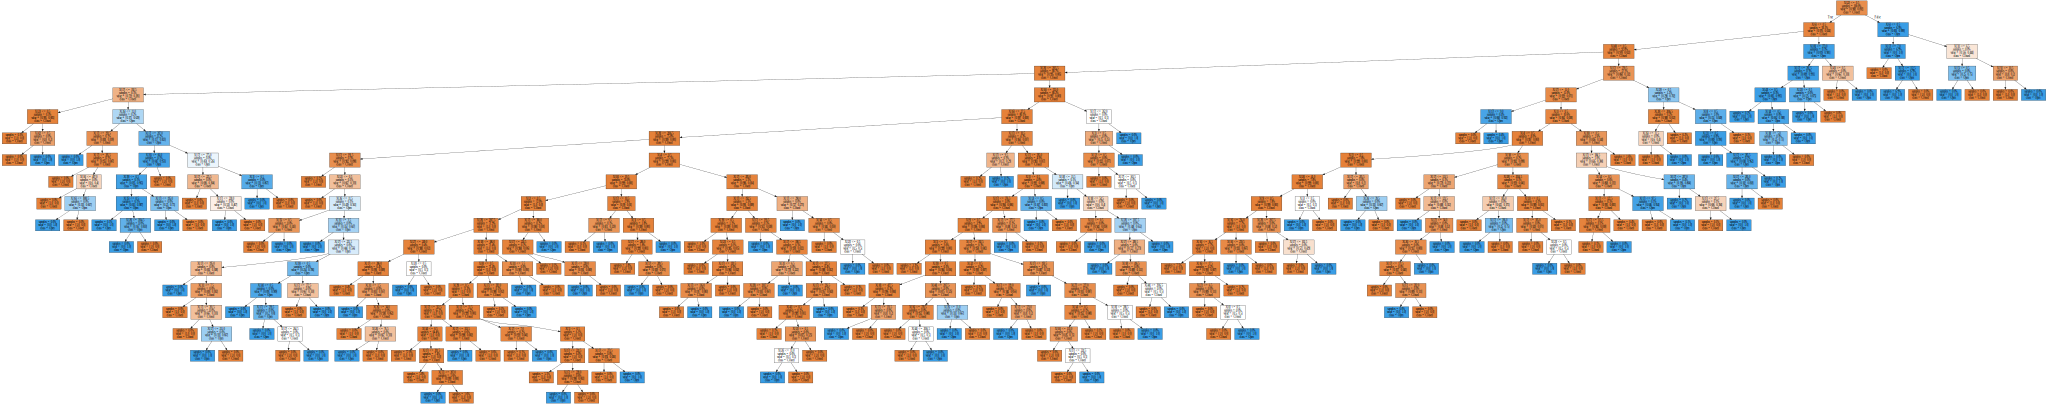

In [44]:
# Visualize decision tree
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    # feature_names=encoder.feature_names, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

# Try xgboost

In [63]:
from xgboost import XGBClassifier

one_hot_encoder = ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True)
X_train_encoded = one_hot_encoder.fit_transform(X_train)
X_val_encoded = one_hot_encoder.transform(X_val)

ordinal_encoder = ce.OrdinalEncoder(cols=high_cardinality)
X_train_encoded = ordinal_encoder.fit_transform(X_train_encoded)
X_val_encoded = ordinal_encoder.transform(X_val_encoded)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model = XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, n_jobs=-1)

model.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-error:0.007092	validation_1-error:0.006942
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.007092	validation_1-error:0.006942
[2]	validation_0-error:0.007005	validation_1-error:0.006892
[3]	validation_0-error:0.005506	validation_1-error:0.005693
[4]	validation_0-error:0.005519	validation_1-error:0.005743
[5]	validation_0-error:0.005594	validation_1-error:0.006043
[6]	validation_0-error:0.005569	validation_1-error:0.005843
[7]	validation_0-error:0.005544	validation_1-error:0.005843
[8]	validation_0-error:0.004707	validation_1-error:0.004645
[9]	validation_0-error:0.004707	validation_1-error:0.004645
[10]	validation_0-error:0.004407	validation_1-error:0.004445
[11]	validation_0-error:0.004582	validation_1-error:0.004545
[12]	validation_0-error:0.003346	validation_1-error:0.003146
[13]	validation_0-error:0.002872	validation_1-error:0.00

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [59]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier()
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

accuracy_score(y_val, y_pred)

0.9961044798481746

In [61]:
model = XGBClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1, learning_rate=0.1, max_depth=7)

model.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-error:0.007092	validation_1-error:0.007741
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.007079	validation_1-error:0.007741
[2]	validation_0-error:0.007079	validation_1-error:0.007741
[3]	validation_0-error:0.007092	validation_1-error:0.007741
[4]	validation_0-error:0.007092	validation_1-error:0.007741
[5]	validation_0-error:0.007092	validation_1-error:0.007741
[6]	validation_0-error:0.007404	validation_1-error:0.008091
[7]	validation_0-error:0.007104	validation_1-error:0.007691
[8]	validation_0-error:0.005768	validation_1-error:0.006293
[9]	validation_0-error:0.005781	validation_1-error:0.006393
[10]	validation_0-error:0.005694	validation_1-error:0.006343
[11]	validation_0-error:0.005681	validation_1-error:0.006243
[12]	validation_0-error:0.005244	validation_1-error:0.005644
[13]	validation_0-error:0.004919	validation_1-error:0.00

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Permutation importance

In [65]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=112, random_state=random_state, n_jobs=-1, max_depth=3, min_samples_leaf=3)

model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=112,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [67]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, n_iter=7, random_state=random_state, scoring='accuracy')

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=3,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=112,
                                                       n

In [0]:
feature_names = X_val.columns.to_list()
importances = pd.Series(permuter.feature_importances_, feature_names)
importances_std = pd.Series(permuter.feature_importances_std_, feature_names)

In [70]:
importances

Agency                       -1.355584e-04
Initial Request Type          0.000000e+00
Track Type                   -1.426930e-05
Days Opened                  -7.134652e-05
Closed Date                   6.302752e-02
Days to Process               4.994257e-05
Disposition                   5.478699e-02
Disposition "Other" Reason   -7.848118e-05
Exemptions Used              -2.853861e-05
Fiscal Year Received          1.426930e-05
Backlogged Request            2.140396e-05
Month Received                7.134652e-05
Month Received Name           3.172066e-17
Fiscal Year Perfected         0.000000e+00
dtype: float64

In [71]:
importances_std

Agency                        0.000035
Initial Request Type          0.000000
Track Type                    0.000051
Days Opened                   0.000045
Closed Date                   0.000704
Days to Process               0.000000
Disposition                   0.000430
Disposition "Other" Reason    0.000036
Exemptions Used               0.000036
Fiscal Year Received          0.000023
Backlogged Request            0.000025
Month Received                0.000059
Month Received Name           0.000038
Fiscal Year Perfected         0.000000
dtype: float64

In [74]:
pd.DataFrame({'importance':importances, 'std':importances_std}).sort_values(by='importance', ascending=False)

,importance,std
Closed Date,6.302752e-02,0.000704
Disposition,5.478699e-02,0.000430
Month Received,7.134652e-05,0.000059
Days to Process,4.994257e-05,0.000000
Backlogged Request,2.140396e-05,0.000025
Fiscal Year Received,1.426930e-05,0.000023
Month Received Name,3.172066e-17,0.000038
Initial Request Type,0.000000e+00,0.000000
Fiscal Year Perfected,0.000000e+00,0.000000
Track Type,-1.426930e-05,0.000051


In [75]:
eli5.show_weights(permuter, feature_names=feature_names)

Weight,Feature
0.0630 ± 0.0014,Closed Date
0.0548 ± 0.0009,Disposition
0.0001 ± 0.0001,Month Received
0.0000 ± 0.0000,Days to Process
0.0000 ± 0.0000,Backlogged Request
0.0000 ± 0.0000,Fiscal Year Received
0.0000 ± 0.0001,Month Received Name
0 ± 0.0000,Fiscal Year Perfected
0 ± 0.0000,Initial Request Type
-0.0000 ± 0.0001,Track Type
